<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Send a Lightcurve to Zooniverse</b> <br>
Author(s): Becky Nevin <br>
Contact author: Becky Nevin<br>
Last verified to run: 2025-04-09 <br>
LSST Science Pipelines version: Weekly 2025_09 <br>
Container size: small or medium <br>
Targeted learning level: intermediate

**Description:**
Query and send a lightcurve from RSP to Zooniverse

**Skills:** 

**LSST Data Products:** <br>

**Packages:** rubin.cistci, astropy, lsst.daf.butler, lsst.afw.display, lsst.geom 

**Credit:** Rubin tutorial notebook 07b, `DP02_07b_Variable_Star_Lightcurves.ipynb`

**Support:** Support is available and questions are welcome - (cscience@lsst.org)

## 1. Introduction <a class="anchor" id="first-bullet"></a>
This notebook will guide a PI through the process of sending a lightcurve of a variable star from the Rubin Science Platform (RSP) to the Zooniverse.

It is recommended to run the `01_Introduction_to_Citsci_Pipeline.ipynb` notebook first, which provides an introduction to sending images to Zooniverse.

It is also recommended to explore the DP0.2 `tutorial-notebooks/` folder in your home directory, specifically tutorial `DP02_07b_Variable_Star_Lightcurves.ipynb`.

### 1.1 Package imports <a class="anchor" id="second-bullet"></a>

#### Install Pipeline Package

First, install the Rubin Citizen Science Pipeline package by doing the following:

1. Open up a New Launcher tab
2. In the "Other" section of the New Launcher tab, click "Terminal"
3. Use `pip` to install the `rubin.citsci` package by entering the following command:
```
pip install rubin.citsci
```
Note that this package will soon be installed directly on RSP.

If this package is already installed, make sure it is updated:
```
pip install --upgrade rubin.citsci
```

4. Confirm the next cell containing `from rubin.citsci import pipeline` works as expected and does not throw an error

In [2]:
from rubin.citsci import pipeline
import utils
import numpy as np
import pandas as pd
import os
import astropy
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import lsst.afw.display as afwdisplay
afwdisplay.setDefaultBackend("matplotlib")

### 1.2 Define functions and parameters <a class="anchor" id="third-bullet"></a>
If you haven't already, [make a Zooniverse account](https://www.zooniverse.org/accounts/registerhttps://www.zooniverse.org/accounts/register) and create your project.

IMPORTANT: Your Zooniverse project must be set to "public", a "private" project will not work. Select this setting under the "Visibility" tab, (it does not need to be set to live). 

Supply the email associated with your Zooniverse account, and then follow the instructions in the prompt to log in and select your project by slug name.

A "slug" is the string of your Zooniverse username and your project name without the leading forward slash, for instance: "username/project-name". [Click here for more details](https://www.zooniverse.org/talk/18/967061?comment=1898157&page=1).

**The `rubin.citsci` package includes a method that creates a Zooniverse project from template. If you wish to use this feature, do not provide a slug_name and run the subsequent cell.**

In [4]:
email = "beckynevin@gmail.com"
cit_sci_pipeline = pipeline.CitSciPipeline()
cit_sci_pipeline.login_to_zooniverse(email)

Loading and running utilities to establish a link with Zooniverse
Enter your Zooniverse username followed by password below
Enter your Zooniverse credentials...


Username:  rebecca.nevin
 ········


You now are logged in to the Zooniverse platform.

*==* Your Project Slugs *==*

rebecca-dot-nevin/galaxy-rotation-fields
rebecca-dot-nevin/test-project
rebecca-dot-nevin/pcw-2023-awesome-citsci-project
rebecca-dot-nevin/template-test-copy-2024-07-09-21-49-53

*==========================*



Which project would you like to connect to? (copy & paste the slug name here)? rebecca-dot-nevin/test-project


Current project set to: rebecca-dot-nevin/test-project


**Run the following cell if you would like to create a new Zooniverse project from the Vera Rubin template**

In [ ]:
cit_sci_pipeline.create_new_project_from_template()

## 2. Make a subject set of a phased lightcurve from a variable star<a class="anchor" id="fourth-bullet"></a>
A subject set is a collection of data (images, plots, etc) that are shown to citizen scientists. It is also the unit of data that is sent to Zooniverse.

This notebook curates a subject set of flipbook images from a variable star to send to Zooniverse. This can be modified to create your own subject set. Your subject set must have 100 objects or less in the testing phase before your project is approved by the EPO Data Rights panel. 

This example makes one lightcurve from a confirmed variable star.

We have simplified this example to only include one imaging band ($r-$band).

In [29]:
import astropy.units as u
from astropy.table import unique
from astropy.timeseries import LombScargle
from lsst.rsp import get_tap_service

def notebook_7b_one_band():

    plt.style.use('tableau-colorblind10')
    params = {'axes.labelsize': 24,
              'font.size': 20,
              'legend.fontsize': 14,
              'xtick.major.width': 3,
              'xtick.minor.width': 2,
              'xtick.major.size': 12,
              'xtick.minor.size': 6,
              'xtick.direction': 'in',
              'xtick.top': True,
              'lines.linewidth': 3,
              'axes.linewidth': 3,
              'axes.labelweight': 3,
              'axes.titleweight': 3,
              'ytick.major.width': 3,
              'ytick.minor.width': 2,
              'ytick.major.size': 12,
              'ytick.minor.size': 6,
              'ytick.direction': 'in',
              'ytick.right': True,
              'figure.figsize': [10, 8],
              'figure.facecolor': 'White'}
    plt.rcParams.update(params)

    all_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
    all_filter_colors = {'u': '#0c71ff', 'g': '#49be61', 'r': '#c61c00',
                          'i': '#ffc200', 'z': '#f341a2', 'y': '#5d0000'}
    all_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

    # Ask the user
    chosen_filter = input(f"Choose a filter from {all_filter_labels}: ").strip()
    
    # Validate
    if chosen_filter not in all_filter_labels:
        raise ValueError(f"Invalid filter: '{chosen_filter}'. Must be one of {all_filter_labels}.")

    # Restrict to just the chosen filter
    plot_filter_labels = [chosen_filter]
    plot_filter_colors = {chosen_filter: all_filter_colors[chosen_filter]}
    plot_filter_symbols = {chosen_filter: all_filter_symbols[chosen_filter]}
    
    service = get_tap_service("tap")

    ra_known_rrl = 62.1479031
    dec_known_rrl = -35.799138

    query = "SELECT TOP 100 "\
        "coord_ra, coord_dec, objectId, "\
        "g_psfFlux, r_psfFlux, i_psfFlux, detect_isPrimary, "\
        "scisql_nanojanskyToAbMag(g_psfFlux) as gPSFMag, "\
        "scisql_nanojanskyToAbMag(r_psfFlux) as rPSFMag, "\
        "scisql_nanojanskyToAbMag(i_psfFlux) as iPSFMag, "\
        "g_extendedness, r_extendedness, i_extendedness "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS'," + str(ra_known_rrl) + ", "\
        + str(dec_known_rrl) + ", 0.001)) = 1 "\
        "AND detect_isPrimary = 1"\
    job = service.submit_job(query)
    job.run()
    job.wait(phases=['COMPLETED', 'ERROR'])
    objs = job.fetch_result().to_table()
    sel_objid = objs[0]['objectId']
    query = "SELECT src.band, src.ccdVisitId, src.coord_ra, src.coord_dec, "\
        "src.objectId, src.psfFlux, src.psfFluxErr, "\
        "scisql_nanojanskyToAbMag(psfFlux) as psfMag, "\
        "visinfo.ccdVisitId, visinfo.band, "\
        "visinfo.expMidptMJD, visinfo.zeroPoint "\
        "FROM dp02_dc2_catalogs.ForcedSource as src "\
        "JOIN dp02_dc2_catalogs.CcdVisit as visinfo "\
        "ON visinfo.ccdVisitId = src.ccdVisitId "\
        "WHERE src.objectId = "+str(sel_objid)+" "
    job = service.submit_job(query)
    job.run()
    job.wait(phases=['COMPLETED', 'ERROR'])
    srcs = job.fetch_result().to_table()
    pick = {}
    for filter in plot_filter_labels:
        pick[filter] = (srcs['band'] == filter)
    fig = plt.figure(figsize=(6, 4))
    plt.plot(srcs[pick['r']]['expMidptMJD'], srcs[pick['r']]['psfMag'],
             'k.', ms=10)
    plt.minorticks_on()
    plt.xlabel('MJD (days)')
    plt.ylabel('r')
    plt.gca().invert_yaxis()
    plt.show()
    mjd_days = {}
    mags = {}
    for filter in plot_filter_labels:
        mjd_days[filter] = np.array(srcs[pick[filter]]['expMidptMJD']) * u.day
        mags[filter] = np.array(srcs[pick[filter]]['psfMag'])
    min_period = 0.05 * u.day
    max_period = 1.05 * u.day
    
    min_freq_search = 1.0 / max_period
    max_freq_search = 1.0 / min_period

    frequency = {}
    power = {}
    for filter in plot_filter_labels:
        frequency[filter], power[filter] =\
            LombScargle(mjd_days[filter], mags[filter]).autopower(minimum_frequency=min_freq_search,
                                                                  maximum_frequency=max_freq_search)

    all_peak_freqs = []

    for filter in plot_filter_labels:
        peakbin = np.argmax(power[filter])
    
        all_peak_freqs.append(frequency[filter][peakbin].value)
        
    all_peak_freqs = np.array(all_peak_freqs)
    
    mean_peak_freq = np.mean(all_peak_freqs)
    
    print('Mean frequency:', mean_peak_freq)
    print('Mean period:', 1.0/mean_peak_freq, ' days')
    print('\nugrizy frequency results:\n', all_peak_freqs)
    best_period = 1/mean_peak_freq
    mjd_norm = {}
    phase = {}
    
    t0 = np.min(mjd_days['r'].value)
    
    for filter in plot_filter_labels:
        mjd_norm[filter] = (mjd_days[filter].value - t0) / best_period
        phase[filter] = np.mod(mjd_norm[filter], 1.0)

    fig = plt.figure(figsize=(6, 4))

    for filter in plot_filter_labels:
        plt.plot(phase[filter], mags[filter]-np.mean(mags[filter]),
                 plot_filter_symbols[filter],
                 color=plot_filter_colors[filter], label=filter)
    plt.hlines(0, 0, 1, linestyle=':', color='Gray')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.xlabel('phase')
    plt.ylabel('mag - mean')
    plt.minorticks_on()
    plt.show()

    return phase[filter], mags[filter]-np.mean(mags[filter]), chosen_filter

Choose a filter from ['u', 'g', 'r', 'i', 'z', 'y']:  r


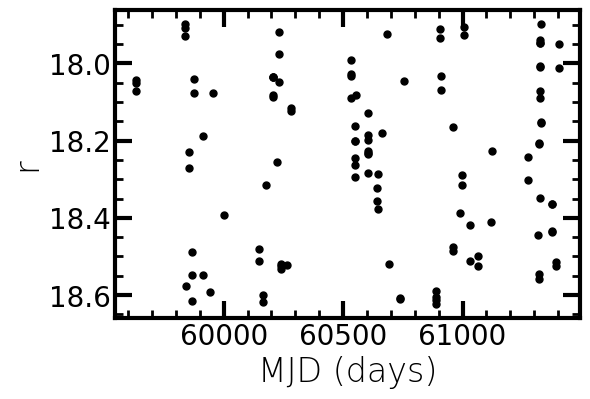

Mean frequency: 1.9626128804293055
Mean period: 0.5095248329264292  days

ugrizy frequency results:
 [1.96261288]


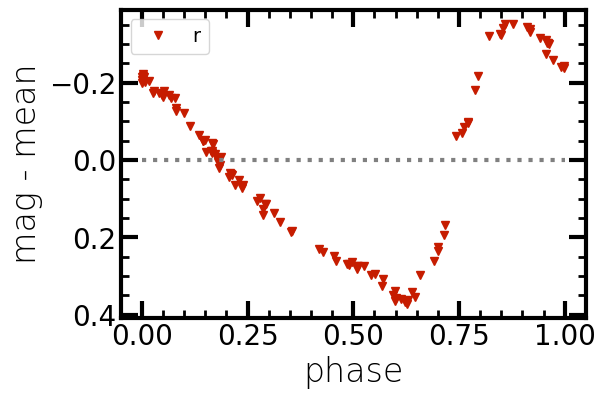

In [30]:
phase, brightness, band = notebook_7b_one_band()

In [28]:
print(phase)

[0.73104474 0.77385784 0.86610627 0.95479261 0.09487645 0.88716485
 0.874154   0.87400372 0.63672456 0.05618072 0.06640358 0.96076189
 0.25108779 0.73621241 0.7353312  0.11363094 0.1109834  0.87917934
 0.27581936 0.29787896 0.88882154 0.47204328 0.09375439 0.48696411
 0.39315506 0.02461061 0.58434194 0.13387949 0.89659373 0.88518127
 0.05357376 0.89571841 0.28997205 0.26439166 0.16184493 0.43702855
 0.29362221 0.93703641 0.29837085 0.89025417 0.88849765 0.04335443
 0.04247323 0.19920522 0.20008642 0.81119945 0.44378703 0.80754511
 0.10980391 0.5146167  0.5384288  0.10435391 0.39068308 0.34492477
 0.54368657 0.34667933 0.13283228 0.26276283 0.84143757 0.05418069
 0.35624048 0.96822533 0.0352509  0.38659353 0.28166311 0.19394744
 0.17245947 0.54651099 0.64765839 0.29255741 0.18450926 0.33436604
 0.33524136 0.96061836 0.55612383 0.14053021 0.6529687  0.66335276]


In [35]:
import pandas as pd
import json

def get_filtered_data(phase, brightness):
    brightness_demeaned = brightness - np.mean(brightness)
    
    # Create DataFrame
    df = pd.DataFrame({
        'phase': phase,
        'relative brightness': brightness_demeaned
    })
    
    # Convert to JSON
    json_data = df.to_json(orient='records')  # Or 'split', 'index', etc.

    return df, json_data

In [36]:
df, json_data = get_filtered_data(phase, brightness)

In [37]:
df

,phase,relative brightness
0,0.593895,0.349467
1,0.237756,0.071435
2,0.699522,0.236358
3,0.700404,0.226043
4,0.621295,0.367469
...,...,...
110,0.278655,0.097648
111,0.508259,0.273983
112,0.000881,-0.199503
113,0.000000,-0.206691


In [38]:
json_data

'[{"phase":0.5938953418,"relative brightness":0.3494671821},{"phase":0.2377564308,"relative brightness":0.0714345923},{"phase":0.6995224502,"relative brightness":0.2363581354},{"phase":0.7004036634,"relative brightness":0.2260426561},{"phase":0.6212953802,"relative brightness":0.3674689506},{"phase":0.2110184535,"relative brightness":0.0350145349},{"phase":0.490624132,"relative brightness":0.2690326396},{"phase":0.2723141184,"relative brightness":0.1057467658},{"phase":0.7630653116,"relative brightness":-0.0846996796},{"phase":0.0992384256,"relative brightness":-0.1203976598},{"phase":0.0016380431,"relative brightness":-0.2156382735},{"phase":0.0043111218,"relative brightness":-0.2152366459},{"phase":0.0007568299,"relative brightness":-0.2155546142},{"phase":0.7714966206,"relative brightness":-0.0957784827},{"phase":0.772381759,"relative brightness":-0.0980527254},{"phase":0.1345634948,"relative brightness":-0.0650505875},{"phase":0.1518143391,"relative brightness":-0.020771794},{"phas

## 3. Preview the json as a plot

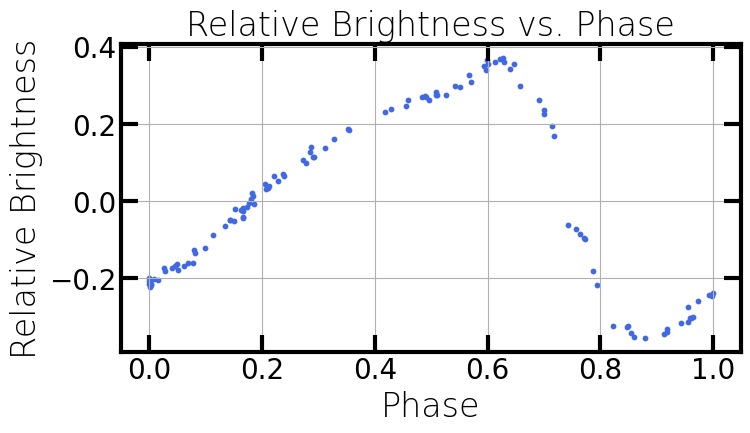

In [41]:
# Parse it into Python objects
data = json.loads(json_data)

# Extract phase and brightness values
phases = [point["phase"] for point in data]
brightness = [point["relative brightness"] for point in data]

# Plot it
plt.figure(figsize=(8, 4))
plt.scatter(phases, brightness, s=10, color='royalblue')
plt.xlabel("Phase")
plt.ylabel("Relative Brightness")
plt.title("Relative Brightness vs. Phase")
plt.grid(True)
plt.show()

## 4. Prepare the manifest
Now that the dataset is curated, it is time to create the manifest file that will be used to upload the dataset to Zooniverse.

In [ ]:
batch_dir = './json_output/'
os.makedirs(batch_dir, exist_ok=True)
print(f"Make the manifest file and save both the manifest "
      f"and the cutout images in this folder: {batch_dir}")
manifest = utils.make_manifest_with_json(
    json_data, batch_dir)

In [ ]:
manifest_path = cit_sci_pipeline.write_manifest_file(
    manifest, batch_dir)
print("The manifest CSV file can be found "
      f"at the following relative path: {manifest_path}")

## 5. Send the data to Zooniverse
Zip up the data and send it to the Zooniverse.

### 5.1 Zip up the data
Running the below cell will zip up all the cutouts into a single file - this can take 5 to 10 minutes for large data sets (> 5k cutouts).

In [ ]:
zip_path = cit_sci_pipeline.zip_image_cutouts(batch_dir)
print(zip_path)

In [ ]:
subject_set_name = ""
cit_sci_pipeline.send_image_data(subject_set_name, zip_path, flipbook=True)